In [57]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
data_path = r'../data/clean_df.csv.gz'
df = pd.read_csv(data_path).drop('Unnamed: 0', axis=1)
df.head()

,Unnamed: 0.1,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,...,SUNRISE,SUNSET,DURING DAYTIME,TOTAL PEDESTRIAN CASUALTIES,WEEKDAY,WEEKEND,DAYS FROM NEW YEARS,DAYS FROM CHRISTMAS,DAYS FROM JULY 4,YEAR-MONTH
0,0,2017-06-26,2021-01-04 22:00:00,MANHATTAN,10002.0,40.718270,-73.99072,POINT (-73.99072 40.71827),ALLEN ST,BROOME ST,...,05:26:50.135154,20:30:58.130198,0,0,SUNDAY,1,176 days,-182 days,-8 days,2017-06
1,1,2017-07-14,2021-01-04 13:17:00,MANHATTAN,10028.0,40.783180,-73.94362,POINT (-73.94362 40.78318),FDR DR,NaN,...,05:37:24.789346,20:26:02.288154,1,0,THURSDAY,0,194 days,-164 days,10 days,2017-07
2,2,2017-07-04,2021-01-04 14:00:00,BRONX,10472.0,40.833557,-73.85774,POINT (-73.85774 40.833557),WESTCHESTER AVE,PUGSLEY AVE,...,05:30:38.196702,20:30:07.392853,1,0,MONDAY,0,184 days,-174 days,0 days,2017-07
3,3,2017-07-17,2021-01-04 21:03:00,MANHATTAN,10031.0,40.833843,-73.94851,POINT (-73.94851 40.833843),RIVERSIDE DR,WEST 155 ST,...,05:39:47.424209,20:24:10.403806,0,1,SUNDAY,1,197 days,-161 days,13 days,2017-07
4,4,2017-06-26,2021-01-04 15:35:00,BROOKLYN,11212.0,40.654434,-73.92139,POINT (-73.92139 40.654434),REMSEN AVE,LINDEN BLVD,...,05:26:50.135154,20:30:58.130198,1,0,SUNDAY,1,176 days,-182 days,-8 days,2017-06


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1382598 entries, 0 to 1382597
Data columns (total 43 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   Unnamed: 0.1                   1382598 non-null  int64  
 1   CRASH DATE                     1382598 non-null  object 
 2   CRASH TIME                     1382598 non-null  object 
 3   BOROUGH                        1367112 non-null  object 
 4   ZIP CODE                       1382598 non-null  float64
 5   LATITUDE                       1382598 non-null  float64
 6   LONGITUDE                      1382598 non-null  float64
 7   LOCATION                       1382598 non-null  object 
 8   ON STREET NAME                 1122268 non-null  object 
 9   CROSS STREET NAME              908183 non-null   object 
 10  OFF STREET NAME                214199 non-null   object 
 11  NUMBER OF PERSONS INJURED      1382586 non-null  float64
 12  NUMBER OF PERS

In [4]:
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'])
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])

<AxesSubplot:>

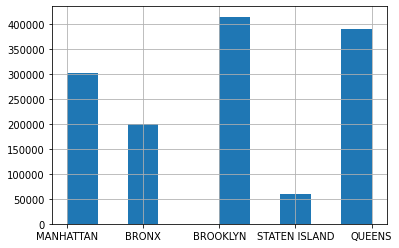

In [5]:
df['BOROUGH'].hist()

A lot more accidents in Brooklyn and Queens than in Manhattan. Unexpected. Let's examine each of those boroughs and determine if there are specific "danger areas."

In [6]:
brooklyn = df[df['BOROUGH'] == 'BROOKLYN']
brooklyn.loc[:,'ON STREET NAME'] = brooklyn['ON STREET NAME'].apply(lambda x: str(x).rstrip())

/home/yehuda/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


##### Create a table that examines the number of accidents on a street, divided by the max Euclidean distance between the furthest accidents. You can do this by creating a Euclidean distance for each accident from (0,0) and taking the max for that column for each street name.

### Accidents pivot table

In [8]:
lat_range = brooklyn.groupby('ON STREET NAME')['LATITUDE'].max() - brooklyn.groupby(('ON STREET NAME'))['LATITUDE'].min()
lon_range = brooklyn.groupby('ON STREET NAME')['LONGITUDE'].max() - brooklyn.groupby(('ON STREET NAME'))['LONGITUDE'].min()
euclidean_range = np.sqrt(lat_range ** 2 + lon_range ** 2)

In [9]:
brooklyn.loc[:,'RANGE'] = brooklyn['ON STREET NAME'].apply(lambda x: euclidean_range[x])

/home/yehuda/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/yehuda/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [10]:
euclidean_range_no_nans = euclidean_range[euclidean_range.index != 'nan']
euclidean_range_no_nans.sort_values(ascending=False)

ON STREET NAME
ATLANTIC AVE           0.307003
60 ST                  0.260309
2 AVE                  0.256652
BELT PKWY              0.235974
HIGHLAND BLVD          0.221694
                         ...   
SEIGAL ST              0.000000
GRAND CENTRAL PKWY     0.000000
MC KENNY ST            0.000000
GRANVILLE PAYNE AVE    0.000000
BRADLEY AVE            0.000000
Length: 1850, dtype: float64

In [11]:
casualties = brooklyn.groupby('ON STREET NAME')['TOTAL PEDESTRIAN CASUALTIES'].sum()
casualties_no_nans = casualties[casualties.index != 'nan']
casualties_no_nans.sort_values(ascending=False)

ON STREET NAME
BEDFORD AVE      691
FLATBUSH AVE     654
ATLANTIC AVE     649
NOSTRAND AVE     649
FULTON ST        598
                ... 
PARK ST            0
ADLER PLACE        0
GOODWIN PLACE      0
PARROTT PLACE      0
CHARLES PLACE      0
Name: TOTAL PEDESTRIAN CASUALTIES, Length: 1850, dtype: int64

In [12]:
euclidean_range.corr(casualties_no_nans)

0.5226733343394376

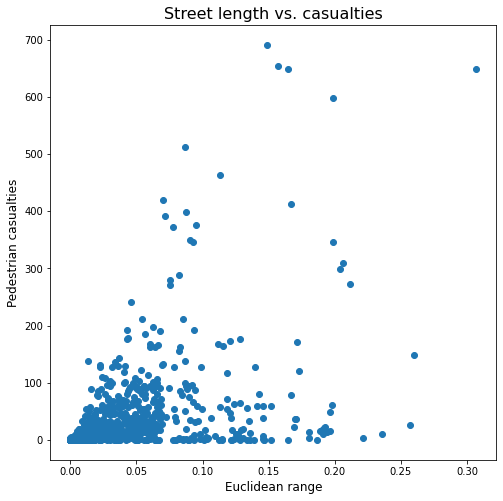

In [13]:
_ = plt.figure(figsize=(8,8))
_ = plt.scatter(euclidean_range_no_nans, casualties_no_nans)
_ = plt.xlabel('Euclidean range', fontsize=12)
_ = plt.ylabel('Pedestrian casualties', fontsize=12)
_ = plt.title('Street length vs. casualties', fontsize=16)

The pedestrian casualty count does not completely correlate to the Euclidean length of the street. For example, the highest pedestrian casualty count is on Bedford Ave, but the longest street by Euclidean measurement is Atlantic Ave.

In [14]:
street_count = brooklyn.groupby('ON STREET NAME')['COLLISION_ID'].count()
street_count

ON STREET NAME
1 AVE            148
1 COURT            5
1 PLACE           45
1 ST              73
10 AVE           453
               ...  
WYONA ST         128
WYTHE AVE        676
WYTHE PLACE        9
YORK ST           96
nan            79597
Name: COLLISION_ID, Length: 1851, dtype: int64

In [15]:
streets = pd.DataFrame({'# ACCIDENTS':street_count, 'MAP RANGE':euclidean_range, 'CASUALTIES':casualties},
                              index=euclidean_range.index)
streets.sort_values('CASUALTIES', ascending=False).head(10)

,# ACCIDENTS,MAP RANGE,CASUALTIES
ON STREET NAME,,,
nan,79597,0.590046,4556
BEDFORD AVE,4394,0.148520,691
FLATBUSH AVE,6973,0.156919,654
ATLANTIC AVE,10568,0.307003,649
NOSTRAND AVE,4710,0.164418,649
FULTON ST,3595,0.198748,598
5 AVE,2073,0.086465,512
BRDWAY,2449,0.113520,463
UTICA AVE,4032,0.069808,420


In [16]:
streets = streets.drop(streets.sort_values('CASUALTIES', ascending=False).index[0], axis=0)
streets.sort_values('CASUALTIES', ascending=False).head(10)

,# ACCIDENTS,MAP RANGE,CASUALTIES
ON STREET NAME,,,
BEDFORD AVE,4394,0.148520,691
FLATBUSH AVE,6973,0.156919,654
ATLANTIC AVE,10568,0.307003,649
NOSTRAND AVE,4710,0.164418,649
FULTON ST,3595,0.198748,598
5 AVE,2073,0.086465,512
BRDWAY,2449,0.113520,463
UTICA AVE,4032,0.069808,420
OCEAN AVE,2781,0.167038,412


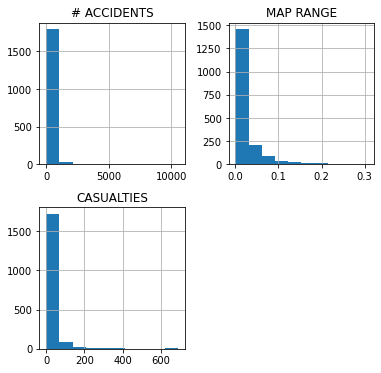

In [17]:
_ = streets.hist(figsize=(6,6))

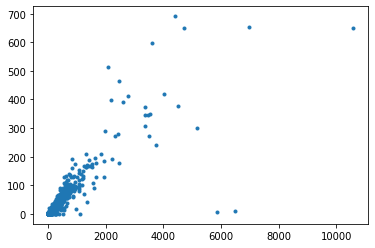

In [18]:
_ = plt.plot(streets['# ACCIDENTS'], streets['CASUALTIES'], marker='.', linestyle='none')

In [19]:
streets.corr()

,# ACCIDENTS,MAP RANGE,CASUALTIES
# ACCIDENTS,1.000000,0.569075,0.862122
MAP RANGE,0.569075,1.000000,0.522673
CASUALTIES,0.862122,0.522673,1.000000


Atlantic Ave is clearly an outlier with regard to number of accidents and number of casualties (since those are highly correlated, this is not a surprise). Is it related to the fact that the street is longer than most others?

In [20]:
map_head = streets.sort_values('MAP RANGE', ascending=False).head(50)
map_head.head()

,# ACCIDENTS,MAP RANGE,CASUALTIES
ON STREET NAME,,,
ATLANTIC AVE,10568,0.307003,649
60 ST,1195,0.260309,149
2 AVE,603,0.256652,26
BELT PKWY,6493,0.235974,11
HIGHLAND BLVD,171,0.221694,3


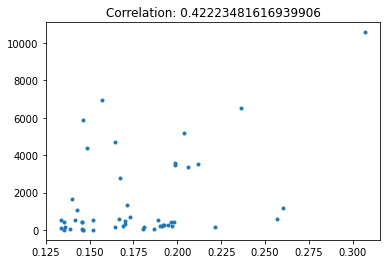

In [21]:
_ = plt.plot(map_head['MAP RANGE'], map_head['# ACCIDENTS'], marker='.', linestyle='none')
_ = plt.title('Correlation: {}'.format(map_head['MAP RANGE'].corr(map_head['# ACCIDENTS'])))

While a single accident may occur on a street, we are more interested in patterns. As such, we should consider dropping records where `# ACCIDENTS` equals 1.

In [22]:
len(streets[streets['# ACCIDENTS'] == 1])

251

In [23]:
more_accidents = streets[streets['# ACCIDENTS'] >= 10]
more_accidents.sort_values('# ACCIDENTS', ascending=True).head(10)

,# ACCIDENTS,MAP RANGE,CASUALTIES
ON STREET NAME,,,
BEAUMONT ST,10,0.004908,1
SEABREEZE AVE,10,0.004210,1
FRIEL PLACE,10,0.002299,0
LITTLE NASSAU ST,10,0.000869,0
BRIGHTON 14 ST,10,0.002448,0
SCHENCK ST,10,0.004164,1
CHERRY ST,10,0.003115,0
DOBBIN ST,10,0.003831,0
SHERMAN ST,10,0.009318,1


In [24]:
more_accidents.corr()

,# ACCIDENTS,MAP RANGE,CASUALTIES
# ACCIDENTS,1.000000,0.562414,0.853421
MAP RANGE,0.562414,1.000000,0.506836
CASUALTIES,0.853421,0.506836,1.000000


##### Add daytime and weekend data to `more_accidents`

In [25]:
daytime_weekend = df.groupby('ON STREET NAME')[['WEEKEND', 'DURING DAYTIME']].sum()
dt_wk_streets = more_accidents.join(daytime_weekend, how='right')

In [26]:
dt_wk_streets.head()

,# ACCIDENTS,MAP RANGE,CASUALTIES,WEEKEND,DURING DAYTIME
ON STREET NAME,,,,,
1 AVE,148.0,0.090994,3.0,1220,3242
1 COURT,NaN,NaN,NaN,3,4
1 PLACE,45.0,0.005814,0.0,11,38
1 ST,73.0,0.022296,2.0,38,87
10 AVE,453.0,0.118365,54.0,1036,2792


Where are the accidents that don't have street labels? Maybe they're on major highways.

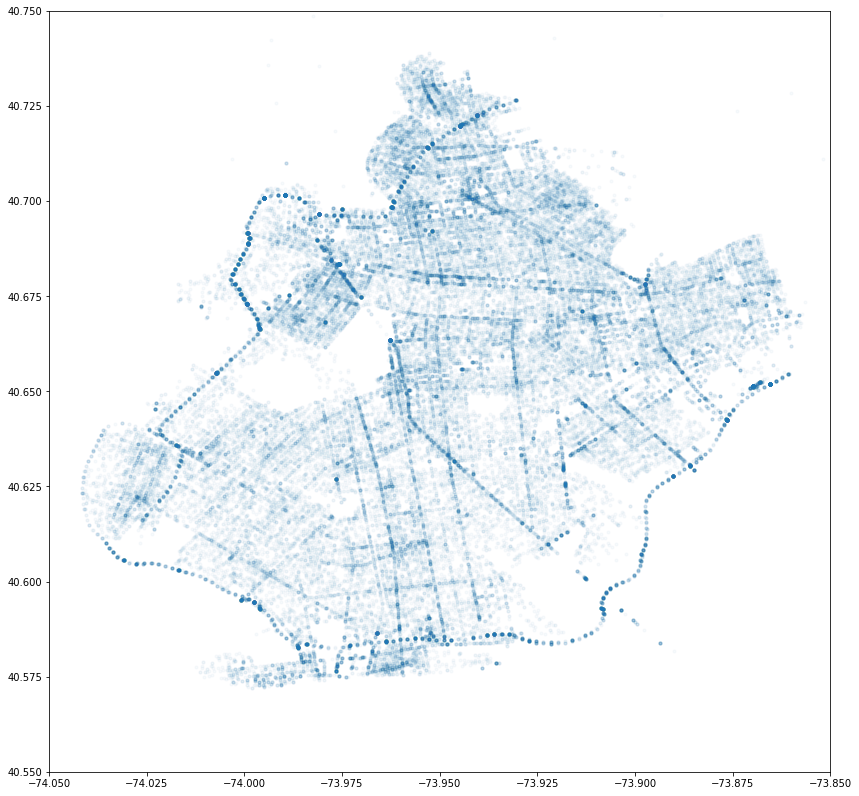

In [27]:
no_streets = df[(df['ON STREET NAME'].isnull() == True) & (df['BOROUGH'] == 'BROOKLYN')]

_ = plt.figure(figsize=(14,14))
_ = plt.plot(no_streets['LONGITUDE'], no_streets['LATITUDE'], marker='.', linestyle='none', alpha=0.03)
_ = plt.xlim(-74.05, -73.85)
_ = plt.ylim(40.55, 40.75)
plt.show()

### Hourly plots

##### Hourly data by borough

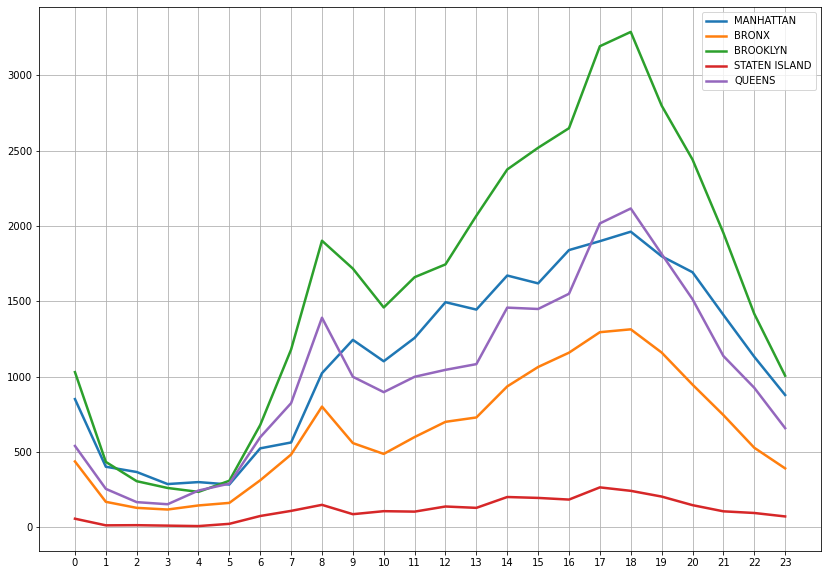

In [28]:
boroughs = df['BOROUGH'].dropna().unique()
plt.figure(figsize=(14,10))
for borough in boroughs:
    hours = df.loc[(df['BOROUGH'] == borough) == True].groupby(df['CRASH TIME'].dt.hour)\
    ['TOTAL PEDESTRIAN CASUALTIES'].sum()
    
    _ = plt.plot(range(0,24), hours, linestyle='-', linewidth=2.5)
    _ = plt.xticks(np.arange(0,24,1))
_ = plt.grid()
_ = plt.legend(boroughs)

1. Manhattan and the Bronx have a spike at 8 AM. Brooklyn hits that same high, but doesn't taper off afterwards. Manhattan doesn't spike at 8 AM at all.
2. All dip at 3 PM and spike at 4 PM then taper into the evenings.

##### Hourly data by day

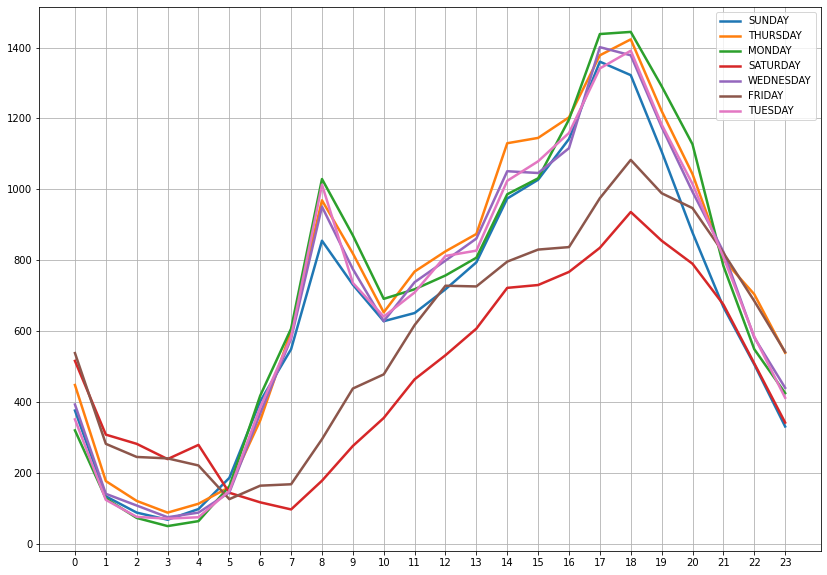

In [29]:
days = df['WEEKDAY'].unique()
plt.figure(figsize=(14,10))
for day in days:
    hours = df.loc[(df['WEEKDAY'] == day) == True].groupby(df['CRASH TIME'].dt.hour)\
    ['TOTAL PEDESTRIAN CASUALTIES'].sum()
    
    _ = plt.plot(range(0,24), hours, linestyle='-', linewidth=2.5)
    _ = plt.xticks(np.arange(0,24,1))
_ = plt.grid()
_ = plt.legend(days)
_ = plt.savefig(r'../Image resources/Weekdays.png')

1. Friday doesn't have an early morning spike.
2. There's always a dip at 3 PM.
3. The afternoon rush-hour spike is larger than the morning rush-hour spike.

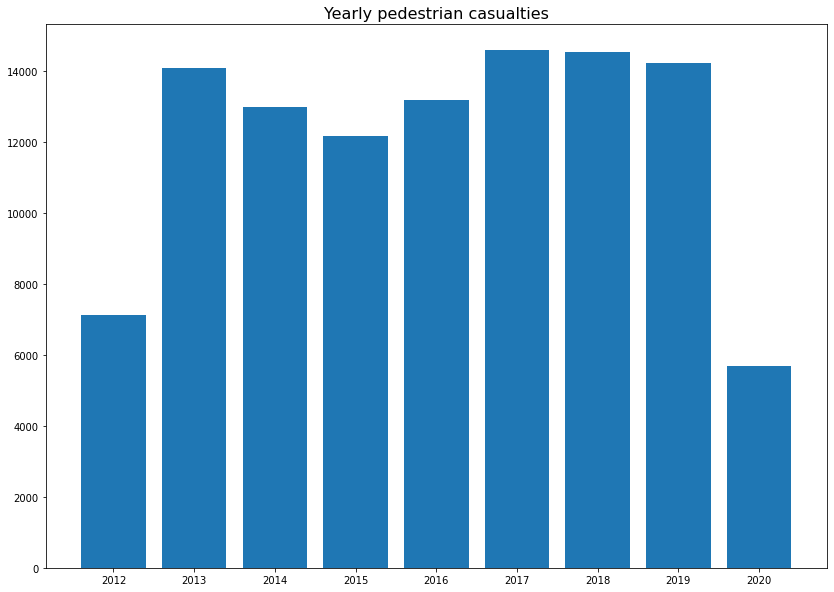

In [30]:
df['CRASH YEAR'] = df['CRASH DATE'].dt.year
year_counts = df.groupby('CRASH YEAR')['TOTAL PEDESTRIAN CASUALTIES'].sum()
_ = plt.figure(figsize=(14,10))
_ = plt.bar(x=year_counts.index, height=year_counts)
_ = plt.xticks(range(2012,2021))
_ = plt.title('Yearly pedestrian casualties', fontsize=16)
_ = plt.savefig(r'../Image resources/Years.png')

2013, 2017 and 2018 seem unusually high compared to 2014-2016. 2020 is understandably low, both because of COVID and because the year is not over yet.

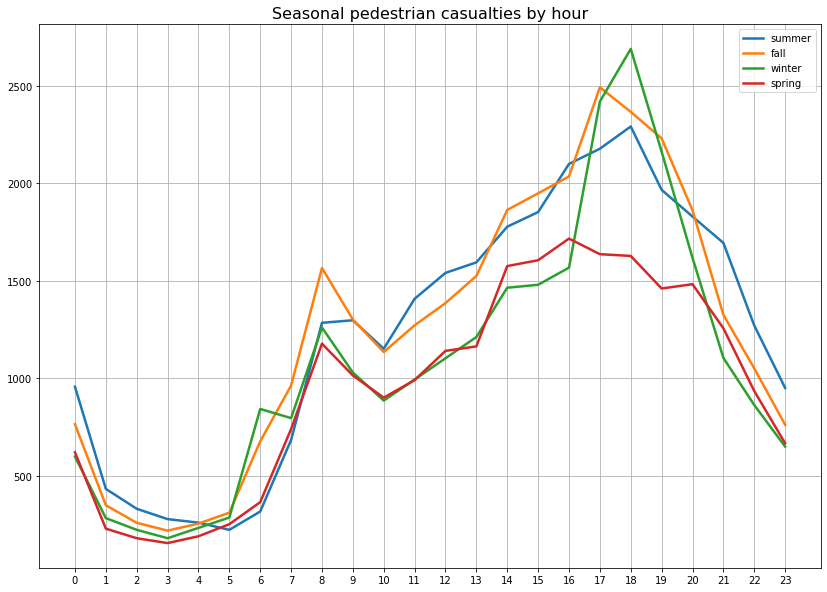

In [31]:
seasons = df['SEASON'].unique()
plt.figure(figsize=(14,10))
for season in seasons:
    hours = df.loc[(df['SEASON'] == season) == True].groupby(df['CRASH TIME'].dt.hour)\
    ['TOTAL PEDESTRIAN CASUALTIES'].sum()
    

    _ = plt.plot(range(0,24), hours, linestyle='-', linewidth=2.5)
    _ = plt.xticks(np.arange(0,24,1))
_ = plt.grid()
_ = plt.legend(seasons)
_ = plt.title('Seasonal pedestrian casualties by hour', fontsize=16)
_ = plt.savefig(r'../Image resources/Seasons.png')

1. The data follows the same trend in each season.
2. There are more fall accidents than winter accidents in the morning.
3. There are the fewest summer accidents in the morning but the most in the evening.
4. Winter's accidents are second-highest in the morning but extemely low in the evening.

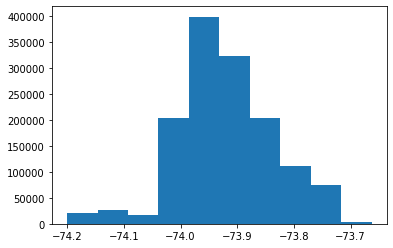

In [32]:
_ = plt.hist(df['LONGITUDE'])

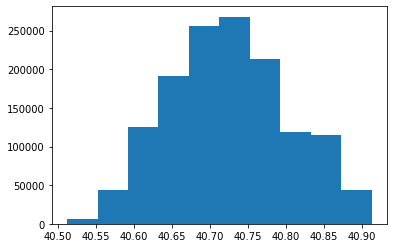

In [33]:
_ = plt.hist(df['LATITUDE'])

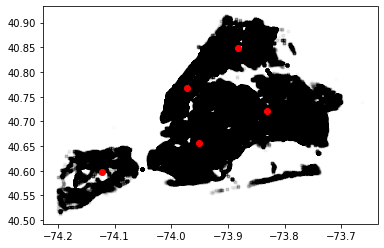

In [34]:
boroughs = ['MANHATTAN','BRONX','BROOKLYN','STATEN ISLAND','QUEENS']
_ = plt.plot(df['LONGITUDE'], df['LATITUDE'], 'k.', alpha=0.01)
for borough in boroughs:
    df_borough = df[df['BOROUGH'] == borough]
    _ = plt.plot(df_borough['LONGITUDE'].mean(), df_borough['LATITUDE'].mean(), 'or')

In [35]:
for borough in boroughs:
    df_borough = df['BOROUGH'] == borough
    borough_lat_mean = df.loc[df_borough,'LATITUDE'].mean()
    borough_lon_mean = df.loc[df_borough,'LONGITUDE'].mean()
    lon_distance = (df.loc[df_borough,'LONGITUDE'] - borough_lon_mean) ** 2
    lat_distance = (df.loc[df_borough,'LATITUDE'] - borough_lat_mean) ** 2
    df.loc[df_borough,'DISTANCE FROM MEAN'] = np.sqrt(lon_distance + lat_distance)

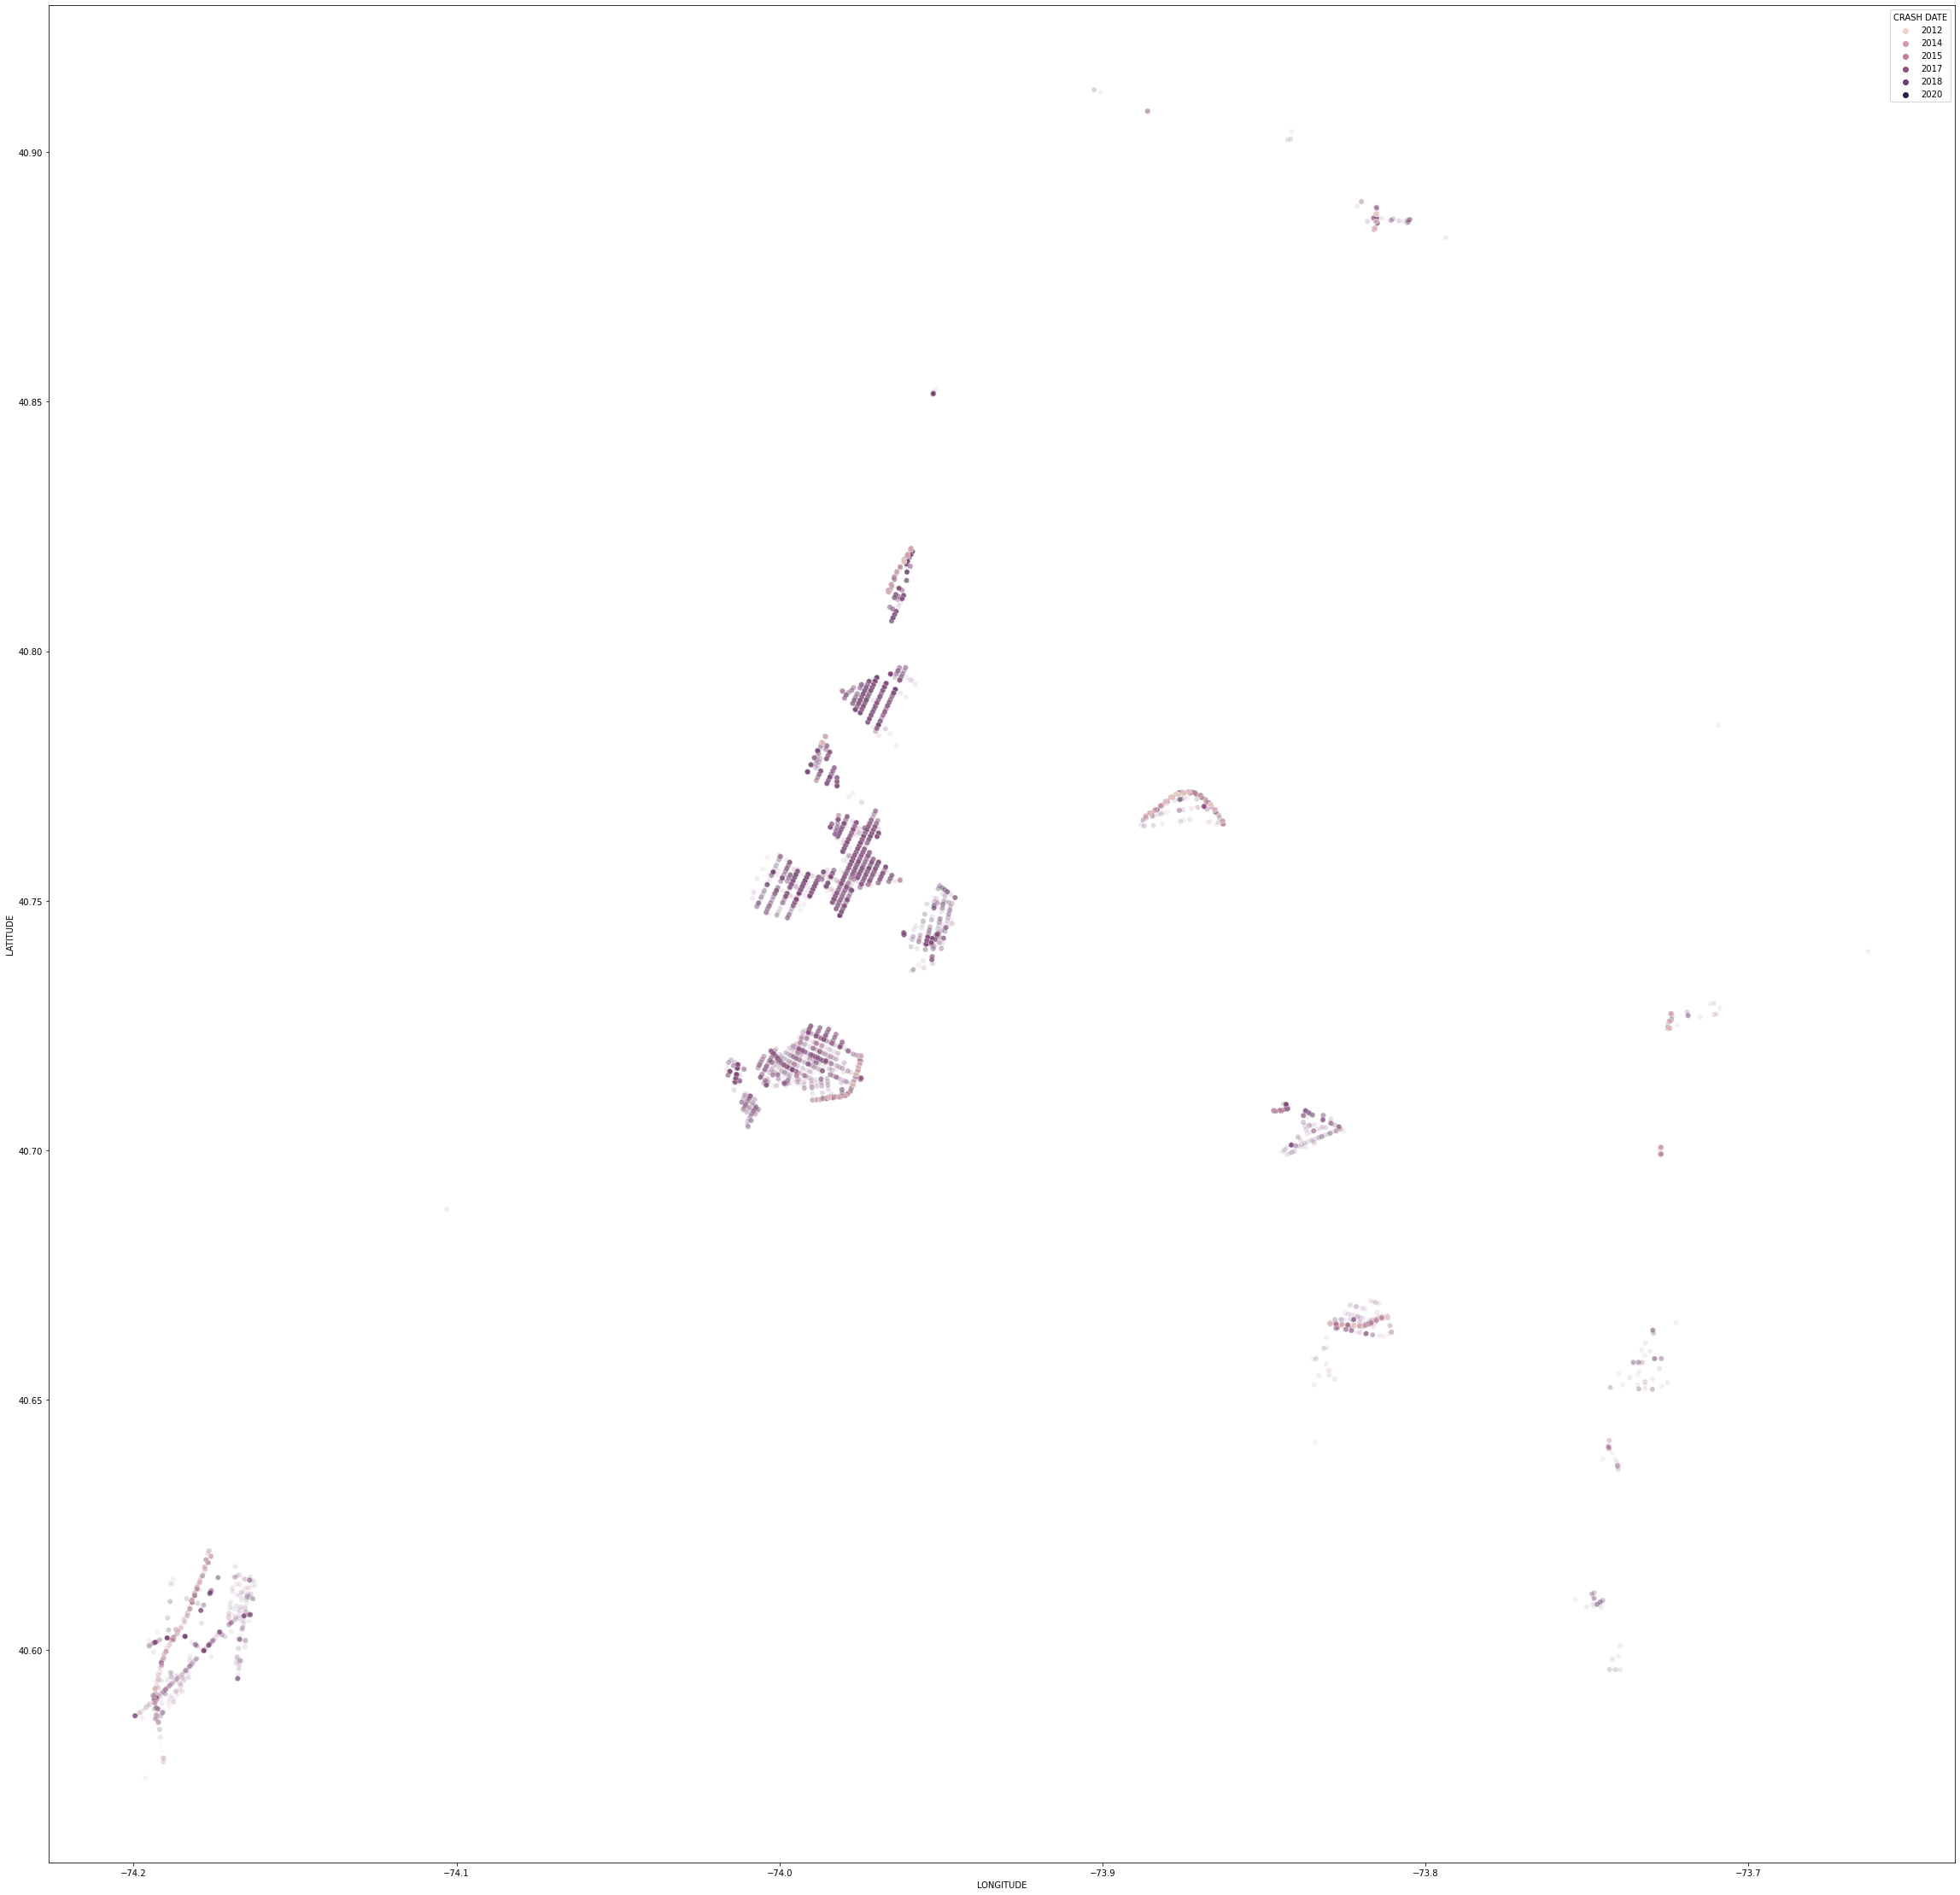

In [36]:
no_borough = df[df['BOROUGH'].isnull() == True]
_ = plt.figure(figsize=(40,40))
_ = sns.scatterplot(x='LONGITUDE',
                    y='LATITUDE',
                    data=no_borough,
                    hue=no_borough['CRASH DATE'].dt.year,
                    cmap='hus1',
                    alpha=0.1)

Null data seems to focus on the borders and through-streets. Are those highways?

In [37]:
no_borough['ON STREET NAME'].value_counts()[lambda x:x>1000]

Series([], Name: ON STREET NAME, dtype: int64)

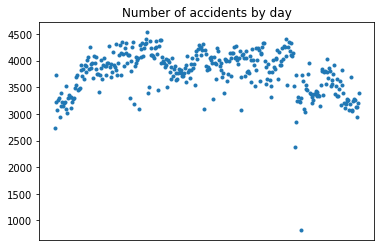

In [38]:
top_counts = df.groupby('DAYS FROM NEW YEARS')['DAYS FROM NEW YEARS'].count()
_ = plt.scatter(top_counts.index, top_counts, marker='.')
_ = plt.title('Number of accidents by day')
_ = plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,   
    top=False,         
    labelbottom=False) 
_ = plt.show()

In [39]:
top_counts[top_counts < 3000]

DAYS FROM NEW YEARS
0 days      2736
103 days    2948
358 days    2371
359 days    2839
365 days     822
96 days     2942
Name: DAYS FROM NEW YEARS, dtype: int64

In [40]:
top_counts.describe()

count     366.000000
mean     3777.590164
std       402.744157
min       822.000000
25%      3532.250000
50%      3849.000000
75%      4062.000000
max      4533.000000
Name: DAYS FROM NEW YEARS, dtype: float64

There is a particular dip around Christmas and New Years. This is to be expected. It is surprising that New Years is relatively so high.

In [41]:
with pd.option_context('display.max_rows', None):
    print(df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().sort_values(ascending=False))

Unspecified                                              533262
Driver Inattention/Distraction                           286915
Failure to Yield Right-of-Way                             87915
Following Too Closely                                     74909
Backing Unsafely                                          58683
Other Vehicular                                           47237
Passing or Lane Usage Improper                            37183
Turning Improperly                                        36381
Passing Too Closely                                       35286
Unsafe Lane Changing                                      28539
Traffic Control Disregarded                               22899
Driver Inexperience                                       22196
Alcohol Involvement                                       14387
Unsafe Speed                                              13779
Reaction to Uninvolved Vehicle                            13322
Prescription Medication                 

It may be worth combining these into a much more limited set of features, e.g. _distracted driver, DUI,_ etc.

### Term distribution

We are count-vectorizing `ON STREET NAME` and `CROSS STREET NAME`. However, a problem arises: When writing down street names, a shorthand is often used, such as "St" for "Street." This will cause a significant amount of confusion in the model. We must determine if this is occurring, and if so, is it on a significant scale.

In [42]:
df['ON STREET NAME'].fillna('', inplace=True)
count = CountVectorizer(min_df=30, max_df=0.9)
count_vec = count.fit_transform(df['ON STREET NAME'])
count_df = pd.DataFrame.sparse.from_spmatrix(count_vec)

In [43]:
alt_terms = [['st','street'],
             ['ave','avenue'],
             ['blvd','boulevard'],
             ['rd','road'],
             ['dr','drive'],
             ['crescent','cresc'],
             ['place','pl'],
             ['court','ct'],
             ['terrace','ter'],
             ['highway','hwy'],
             ['parkway','pkwy'],
             ['expressway','expwy'],
             ['junction','jct'],
             ['lane','ln'],
             ['square','sqr'],
             ['extension','ext'],
             ['freeway','frwy'],
             ['plaza','plz'],
             ['tunnel','tunl'],
             ['turnpike','tpke']
            ]
for term in alt_terms:
    try:
        print(term[0], count.vocabulary_[term[0]],
             term[1], count.vocabulary_[term[1]])
    except KeyError:
        continue

It appears to be a major issue. We will have to clean this.

In [44]:
alt_terms = ['STREET',
             'AVENUE',
             'BOULEVARD',
             'ROAD',
             'DRIVE',
             'PARKWAY',
             'EXPRESSWAY'
            ]
clean_terms = ['ST',
               'AVE',
               'BLVD',
               'RD',
               'DR',
               'PKWY',
               'EXPWY'
              ]
def alt_terms_clean(string):
    for alt, clean in zip(alt_terms, clean_terms):
        string = string.strip().replace(alt, clean)
    return string

df['ON STREET NAME'] = df['ON STREET NAME'].map(alt_terms_clean)

In [45]:
%%timeit
df['ON STREET NAME'].map(alt_terms_clean)

1.11 s ± 18.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
%%timeit
df['ON STREET NAME'].map(alt_terms_clean)

1.12 s ± 32.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
df['CROSS STREET NAME'].fillna('', inplace=True)
df['CROSS STREET NAME'].map(alt_terms_clean)

0             BROOME ST
1                      
2           PUGSLEY AVE
3           WEST 155 ST
4           LINDEN BLVD
               ...     
1382593    CLARENDON RD
1382594    SUTPHIN BLVD
1382595         104 AVE
1382596    CATHERINE ST
1382597          32 AVE
Name: CROSS STREET NAME, Length: 1382598, dtype: object

In [48]:
df = df.sort_values(by='YEAR-MONTH', ascending=True)

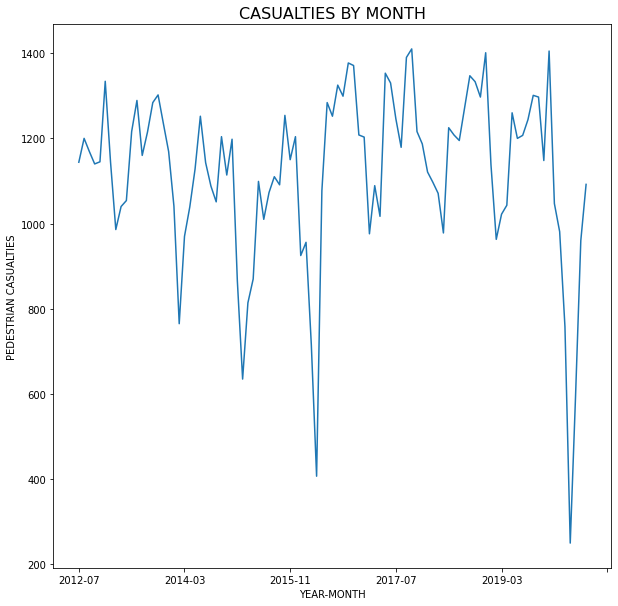

In [49]:
_ = plt.figure(figsize=(10,10))
_ = df.groupby('YEAR-MONTH')['TOTAL PEDESTRIAN CASUALTIES'].sum().plot()
_ = plt.title('CASUALTIES BY MONTH', fontsize=16)
_ = plt.ylabel('PEDESTRIAN CASUALTIES')
_ = plt.savefig(r'../Image resources/Casualties by month.png')

In [50]:
time_series = df.groupby('YEAR-MONTH')['TOTAL PEDESTRIAN CASUALTIES'].sum()
adf = adfuller(time_series)

p_value = adf[0]
critical_value = adf[4]['5%']
reject_hypothesis = 'do not' if critical_value < p_value else ''

print(f'The p-value of the Dickey Fuller test is {p_value}.')
print(f'The critical value is {critical_value}.')
print(f'We {reject_hypothesis} reject the null hypothesis that the time series is non-stationary.')

The p-value of the Dickey Fuller test is -1.194773066245005.
The critical value is -2.8966159448223734.
We do not reject the null hypothesis that the time series is non-stationary.


In [56]:
kpss(time_series, nlags='auto')

/home/yehuda/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)


(0.09800063125555089,
 0.1,
 4,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

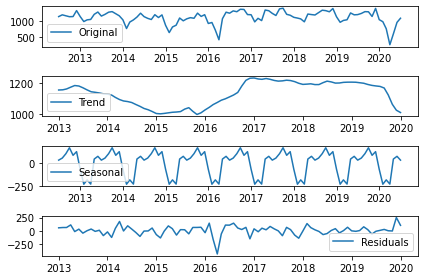

In [80]:
time_series.index = pd.to_datetime(time_series.index)
decomposition = seasonal_decompose(time_series)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(time_series, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

In [101]:
def evaluate_arima_model(data, arima_order):
    split=int(len(data) * 0.8) 
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    predictions = list()
    for i in range(len(test)): 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    error = mean_squared_error(test, predictions)
    return error

def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_arima = mse, order
                    print('ARIMA%s MSE=%.12f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.12f' % (best_arima, best_score))
    return best_arima

p = [x for x in range(0, 3)]
d = [x for x in range(0, 3)]
q = [x for x in range(0, 3)]

best_arima = evaluate_models(time_series, p, d, q)

ARIMA(0, 0, 1) MSE=46665.112810551764
ARIMA(0, 0, 2) MSE=43546.948947604113
ARIMA(0, 1, 1) MSE=51346.918104302953
ARIMA(0, 1, 2) MSE=55832.178749241903
ARIMA(0, 2, 1) MSE=50727.206157426015
ARIMA(0, 2, 2) MSE=53180.889580973926
ARIMA(1, 0, 0) MSE=42651.451621749045
ARIMA(1, 0, 1) MSE=41801.771090802955
ARIMA(1, 0, 2) MSE=42447.938054896447
ARIMA(1, 1, 0) MSE=50943.204690592014
ARIMA(1, 1, 1) MSE=45321.745024509692
ARIMA(1, 1, 2) MSE=44586.028050197172
ARIMA(1, 2, 0) MSE=76624.030638381693
ARIMA(2, 0, 0) MSE=41439.534117449723
ARIMA(2, 0, 1) MSE=39903.167827866622
ARIMA(2, 0, 2) MSE=39571.533114537990
ARIMA(2, 1, 0) MSE=51582.460188967118
ARIMA(2, 1, 1) MSE=44258.923904716117
ARIMA(2, 1, 2) MSE=45012.052288670711
ARIMA(2, 2, 0) MSE=66384.796313166284
ARIMA(2, 2, 1) MSE=53588.913544347371
Best ARIMA(2, 0, 2) MSE=39571.533114537990


In [102]:
model = ARIMA(time_series, order=best_arima)
model_fit = model.fit()
forecast = model_fit.forecast(24)

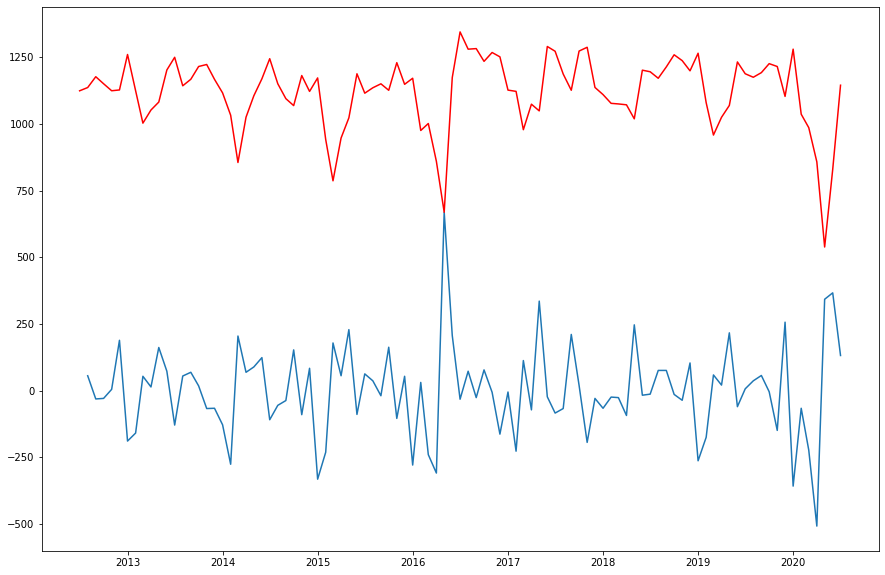

In [103]:
plt.figure(figsize=(15,10))
plt.plot(time_series.diff())
plt.plot(model_fit.predict(), color = 'red')